# Capstone Project : Battle of the Neighborhoods
## Determining the Best Subdistrict in East Jakarta to establish a new coffee shop

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project, we will try to find an optimal location for a new **coffee shop**. This report will be targeted towards anyone that are interested in opening a coffee shop in **Jakarta, Indonesia**. More specifically, the **Eastern Part of Jakarta**. This report also serves as a general report regarding the current brick-and-mortar stores business landscape in East Jakarta.

The current socio-economic condition in Jakarta makes opening a new business may be a harder challenge compared to opening a business in developing countries, as consumer buying power are concentrated just into several affluent subdistricts out of dozens. Therefore, **we are looking for a subdistrict that has a good amount of businesses operating, all the while avoiding subdistricts that already has a coffee shop as a popular venue**.

Despite the scarce availability of the data, we will try to sift through subdistricts of East Jakarta to estimate subdistricts that are guaranteed to have a good amount of engagement with costumers, or foot traffic if we finally decided to open our business there.


## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* the popularity of coffee shops in the subdistrict
* number of cumulative top 10 popular venues in each subdistrict


Following data sources will be needed to extract/generate the required information:
* the list of districts and subdistricts of East Jakarta will be obtained in this [wikipedia](https://id.wikipedia.org/wiki/Kota_Administrasi_Jakarta_Timur) page about East Jakarta
* centers of subdistricts will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **Geopy API**
* the top 10 venues in each subdistrict will be obtained using **Foursquare API**
* coordinate of Jakarta city center will be obtained using **Geopy API**

## Analysis <a name="analysis"></a>

### Importing libraries

In [1]:
import pandas as pd
import requests
import lxml.html as lh
import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

### Reading data into the dataframe

I have compiled the data contained in this [wikipedia](https://id.wikipedia.org/wiki/Kota_Administrasi_Jakarta_Timur) page about subdistricts in East Jakarta into a .csv file. We shall proceed to read it into a dataframe

In [2]:
loc=pd.read_csv('subdistrict_list.csv')
loc.head()

,Kota,Kecamatan,Kelurahan
0,Jakarta Timur,Kramat Jati,Balekambang
1,Jakarta Timur,Kramat Jati,Batu Ampar
2,Jakarta Timur,Kramat Jati,Cawang
3,Jakarta Timur,Kramat Jati,Cililitan
4,Jakarta Timur,Kramat Jati,Dukuh


It gets along nicely I guess. Time to make a new column titled "Address" which will contain the full address of each subdistrict so that we can find out the coordinate points of each subdistrict.

In [3]:
loc['Address'] = loc['Kelurahan'].map(str) + ', ' + loc['Kecamatan'].map(str) + ', ' + loc['Kota'].map(str)
loc.head()

,Kota,Kecamatan,Kelurahan,Address
0,Jakarta Timur,Kramat Jati,Balekambang,"Balekambang, Kramat Jati, Jakarta Timur"
1,Jakarta Timur,Kramat Jati,Batu Ampar,"Batu Ampar, Kramat Jati, Jakarta Timur"
2,Jakarta Timur,Kramat Jati,Cawang,"Cawang, Kramat Jati, Jakarta Timur"
3,Jakarta Timur,Kramat Jati,Cililitan,"Cililitan, Kramat Jati, Jakarta Timur"
4,Jakarta Timur,Kramat Jati,Dukuh,"Dukuh, Kramat Jati, Jakarta Timur"


Now that we have the 'Address' data at hand, we shall 'feed' the address of each subdistrict into the **Geopy API** so that we can know the coordinate of each subdistrict

In [4]:
# 1 - conveneint function to delay between geocoding calls
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="jkt_loc")

from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# 2- - create location column
loc['Location'] = loc['Address'].apply(geocode)

# 3 - create longitude, laatitude and altitude from location column (returns tuple)
loc['Point'] = loc['Location'].apply(lambda loc: tuple(loc.point) if loc else None)

# 4 - split point column into latitude, longitude and altitude columns
loc[['Latitude', 'Longitude', 'Altitude']] = pd.DataFrame(loc['Point'].tolist(), index=loc.index)

In [68]:
loc.head()

,Kota,Kecamatan,Kelurahan,Address,Location,Point,Latitude,Longitude,Altitude
0,Jakarta Timur,Kramat Jati,Balekambang,"Balekambang, Kramat Jati, Jakarta Timur","(SD Negeri Balekambang 01 Pagi, Jalan Rawaelok...","(-6.27496565, 106.85240248467585, 0.0)",-6.274966,106.852402,0.0
1,Jakarta Timur,Kramat Jati,Batu Ampar,"Batu Ampar, Kramat Jati, Jakarta Timur","(Batu Ampar, Daerah Khusus Ibukota Jakarta, Kr...","(-6.28069405, 106.8616419578606, 0.0)",-6.280694,106.861642,0.0
2,Jakarta Timur,Kramat Jati,Cawang,"Cawang, Kramat Jati, Jakarta Timur","(Cawang, Daerah Khusus Ibukota Jakarta, Kramat...","(-6.25067275, 106.8678108565017, 0.0)",-6.250673,106.867811,0.0
3,Jakarta Timur,Kramat Jati,Cililitan,"Cililitan, Kramat Jati, Jakarta Timur","(Cililitan, Daerah Khusus Ibukota Jakarta, Kra...","(-6.2622027, 106.86626737393823, 0.0)",-6.262203,106.866267,0.0
4,Jakarta Timur,Kramat Jati,Dukuh,"Dukuh, Kramat Jati, Jakarta Timur","(Dukuh, Daerah Khusus Ibukota Jakarta, Kramat ...","(-6.29329135, 106.87704516029801, 0.0)",-6.293291,106.877045,0.0


Now, lets make a new dataframe that only contains the data required for our analysis, which are **district, subdistrict, latitude and longitude**

In [69]:
locs=loc[['Kecamatan','Kelurahan','Latitude','Longitude']]
locs.head()

,Kecamatan,Kelurahan,Latitude,Longitude
0,Kramat Jati,Balekambang,-6.274966,106.852402
1,Kramat Jati,Batu Ampar,-6.280694,106.861642
2,Kramat Jati,Cawang,-6.250673,106.867811
3,Kramat Jati,Cililitan,-6.262203,106.866267
4,Kramat Jati,Dukuh,-6.293291,106.877045


#### The final dataframe

Lets rename the columns into English so the Readers can follow along

In [70]:
locs=locs.rename(columns={'Kecamatan': 'District','Kelurahan':'Subdistrict'})
locs.head()

,District,Subdistrict,Latitude,Longitude
0,Kramat Jati,Balekambang,-6.274966,106.852402
1,Kramat Jati,Batu Ampar,-6.280694,106.861642
2,Kramat Jati,Cawang,-6.250673,106.867811
3,Kramat Jati,Cililitan,-6.262203,106.866267
4,Kramat Jati,Dukuh,-6.293291,106.877045


#### Drawing initial map

We'll draw a map that illustrates the locations of each subdistrict. We'll first define the center of Jakarta as the center of the map, followed by putting blue blips representing each subdistrict later.

In [71]:
address = 'Jakarta, Indonesia'

geolocator = Nominatim(user_agent="id_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Jakarta are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Jakarta are -6.1753942, 106.827183.


In [72]:
# create map of Jakarta using latitude and longitude values
map_jakarta = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, district, subdistrict in zip(locs['Latitude'], locs['Longitude'], locs['District'], locs['Subdistrict']):
    label = '{}, {}'.format(subdistrict, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_jakarta)  
    
map_jakarta

In [73]:
locs.shape

(65, 4)

There are 65 subdistrict in total for our analysis.

#### Initalizing Foursquare ID

In [74]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20200101' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

#### Defining the function that will fetch top 100 venues within the radius of 500 m of each neighborhood

In [75]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Subdistrict', 
                  'Subdistrict Latitude', 
                  'Subdistrict Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Using the function

We'll use the function we just defined earlier so that we can find out the top 100 venues in each subdistrict

In [76]:
jakarta_venues = getNearbyVenues(names=locs['Subdistrict'],
                                   latitudes=locs['Latitude'],
                                   longitudes=locs['Longitude']
                                  )

Balekambang
Batu Ampar
Cawang
Cililitan
Dukuh
Kramat Jati
Tengah
Bali Mester
Bidara Cina
Cipinang Besar Selatan
Cipinang Besar Utara
Cipinang Cempedak
Cipinang Muara
Kampung Melayu
Rawa Bunga
Bambu Apus
Ceger
Cilangkap
Cipayung
Lubang Buaya
Munjul
Pondok Ranggon
Setu
Kampung Baru
Cijantung
Gedong
Kalisari
Pekayon
Cakung Barat
Cakung Timur
Jatinegara
Penggilingan
Pulo Gebang
Rawa Terate
Ujung Menteng
Cibubur
Ciracas
Kelapa Dua Wetan
Rambutan
Susukan
Cipinang
Jati
Jatinegara Kaum
Kayu Putih
Pisangan Timur
Pulo Gadung
Rawamangun
Cipinang Melayu
Halim Perdana Kusuma
Kebon Pala
Makasar
Pinang Ranti
Duren Sawit
Klender
Malaka Jaya
Malaka Sari
Pondok Bambu
Pondok Kelapa
Pondok Kopi
Kayu Manis
Kebon Manggis
Pal Meriam
Pisangan Baru
Utan Kayu Selatan
Utan Kayu Utara


#### Let's see the shape of the dataframe

In [77]:
print(jakarta_venues.shape)
jakarta_venues.head()

(431, 7)


,Subdistrict,Subdistrict Latitude,Subdistrict Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Balekambang,-6.274966,106.852402,Holland Bakery,-6.274027,106.856796,Bakery
1,Balekambang,-6.274966,106.852402,Restoran AL-Mukalla,-6.276624,106.855067,Middle Eastern Restaurant
2,Balekambang,-6.274966,106.852402,Al Mukalla,-6.276658,106.855027,Mediterranean Restaurant
3,Balekambang,-6.274966,106.852402,KFC pasar festival,-6.277310,106.853690,American Restaurant
4,Balekambang,-6.274966,106.852402,Angsana Raya,-6.272381,106.849000,Park


#### Grouping by neighborhood to get stats of the venue present in each neighborhood

In [78]:
jakarta_venues.groupby('Subdistrict').count()

,Subdistrict Latitude,Subdistrict Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Subdistrict,,,,,,
Balekambang,5,5,5,5,5,5
Bali Mester,25,25,25,25,25,25
Bambu Apus,6,6,6,6,6,6
Bidara Cina,9,9,9,9,9,9
Cakung Barat,1,1,1,1,1,1
Cakung Timur,15,15,15,15,15,15
Cawang,3,3,3,3,3,3
Ceger,3,3,3,3,3,3
Cibubur,3,3,3,3,3,3


It seems that there's not much brick and mortar stores exist in East Jakarta

#### Calculating how many distinct businesses exist overall

In [79]:
print('There are {} uniques categories.'.format(len(jakarta_venues['Venue Category'].unique())))

There are 117 uniques categories.


#### Analyzing each neighborhood

We'll use dummies to identify how many stores of each category exists in each subdistrict

In [80]:
# one hot encoding
jakarta_onehot = pd.get_dummies(jakarta_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
jakarta_onehot['Subdistrict'] = jakarta_venues['Subdistrict'] 

# move neighborhood column to the first column
fixed_columns = [jakarta_onehot.columns[-1]] + list(jakarta_onehot.columns[:-1])
jakarta_onehot = jakarta_onehot[fixed_columns]

jakarta_onehot.head()

,Subdistrict,Airport Terminal,American Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,Automotive Shop,Bakery,Balinese Restaurant,Bar,...,Stables,Sundanese Restaurant,Supermarket,Tapas Restaurant,Tea Room,Theme Park,Track Stadium,Train Station,Vegetarian / Vegan Restaurant,Video Store
0,Balekambang,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Balekambang,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Balekambang,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Balekambang,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Balekambang,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
jakarta_onehot.shape

(431, 118)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [82]:
jakarta_grouped = jakarta_onehot.groupby('Subdistrict').mean().reset_index()
jakarta_grouped.head()

,Subdistrict,Airport Terminal,American Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,Automotive Shop,Bakery,Balinese Restaurant,Bar,...,Stables,Sundanese Restaurant,Supermarket,Tapas Restaurant,Tea Room,Theme Park,Track Stadium,Train Station,Vegetarian / Vegan Restaurant,Video Store
0,Balekambang,0.0,0.2,0.0,0.00,0.00,0.00,0.2,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,Bali Mester,0.0,0.0,0.0,0.04,0.04,0.04,0.0,0.0,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0
2,Bambu Apus,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,Bidara Cina,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
4,Cakung Barat,0.0,0.0,0.0,0.00,1.00,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0


#### Let's confirm the shape

In [83]:
jakarta_grouped.shape

(62, 118)

#### Let's identify each neighborhood along with the top 5 most common venues

In [84]:
num_top_venues = 5

for hood in jakarta_grouped['Subdistrict']:
    print("----"+hood+"----")
    temp = jakarta_grouped[jakarta_grouped['Subdistrict'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})

----Balekambang----
----Bali Mester----
----Bambu Apus----
----Bidara Cina----
----Cakung Barat----
----Cakung Timur----
----Cawang----
----Ceger----
----Cibubur----
----Cijantung----
----Cililitan----
----Cipayung----
----Cipinang Besar Selatan----
----Cipinang Besar Utara----
----Cipinang Cempedak----
----Cipinang Melayu----
----Cipinang Muara----
----Ciracas----
----Dukuh----
----Duren Sawit----
----Gedong----
----Halim Perdana Kusuma----
----Jati----
----Jatinegara----
----Jatinegara Kaum----
----Kalisari----
----Kampung Baru----
----Kampung Melayu----
----Kayu Manis----
----Kayu Putih----
----Kebon Manggis----
----Kebon Pala----
----Kelapa Dua Wetan----
----Klender----
----Kramat Jati----
----Lubang Buaya----
----Makasar----
----Malaka Jaya----
----Malaka Sari----
----Munjul----
----Pal Meriam----
----Pekayon----
----Penggilingan----
----Pinang Ranti----
----Pisangan Baru----
----Pisangan Timur----
----Pondok Bambu----
----Pondok Kelapa----
----Pondok Kopi----
----Pondok Ranggon--

#### Let's put that into pandas dataframe

#### Defining a function to sort the venues in descending order

In [85]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Creating a new dataframe which shows 10 top venues for each neighborhood

In [86]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Subdistrict']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
jakarta_venues_sorted = pd.DataFrame(columns=columns)
jakarta_venues_sorted['Subdistrict'] = jakarta_grouped['Subdistrict']

for ind in np.arange(jakarta_grouped.shape[0]):
    jakarta_venues_sorted.iloc[ind, 1:] = return_most_common_venues(jakarta_grouped.iloc[ind, :], num_top_venues)

jakarta_venues_sorted.head()

,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Balekambang,Park,Mediterranean Restaurant,American Restaurant,Bakery,Middle Eastern Restaurant,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
1,Bali Mester,Chinese Restaurant,Convenience Store,Jewelry Store,Indonesian Restaurant,Pharmacy,Market,Fast Food Restaurant,Bus Line,Seafood Restaurant,Miscellaneous Shop
2,Bambu Apus,Indonesian Restaurant,High School,Seafood Restaurant,Soup Place,Food Truck,Donut Shop,Falafel Restaurant,Electronics Store,Dumpling Restaurant,Diner
3,Bidara Cina,Pharmacy,Fast Food Restaurant,College Stadium,Grocery Store,Convenience Store,Indonesian Meatball Place,Gas Station,Café,Speakeasy,Diner
4,Cakung Barat,Asian Restaurant,Video Store,Flea Market,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant


#### K-means clustering initialization<a name="clustering"></a>

We'll put all this subdistricts into clusters using K-means method so that we can identify distinct characteristics of each subdistricts. We'll drop the **'Subdistrict'** column to make a new dataframe for the clustering

In [87]:
jakarta_grouped_clustering = jakarta_grouped.drop('Subdistrict', 1)

Lets find out what number of clusters is the most effective in defining the characteristics of subdistricts in East Jakarta

In [140]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(jakarta_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

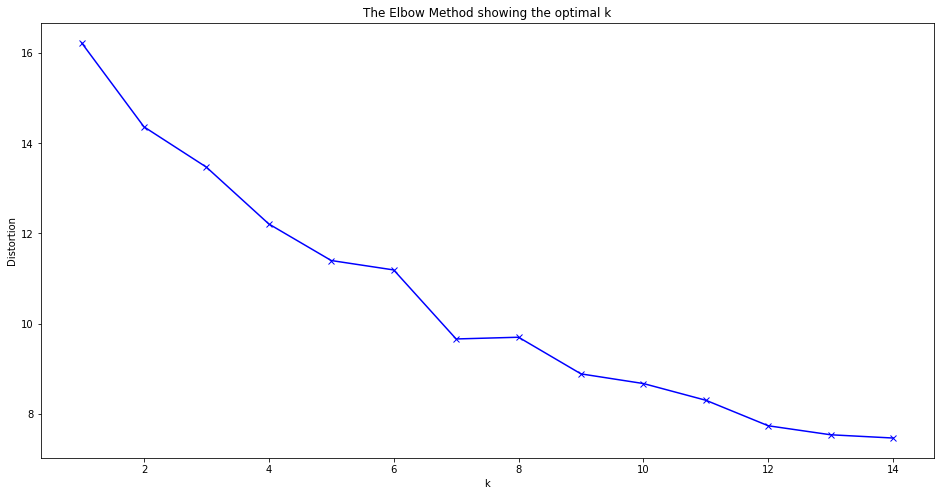

In [141]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Honestly, this doesn't look good. **The subdistricts in East Jakarta are so different from each other that it took 14 clusters to divide the subdistricts. We'll settle with 5 districts** as the 'elbow' can be said apparent at 5, not to mention that too much clusters defeat the main purpose of 'clustering' itself.

In [90]:
#initalize number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(jakarta_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 2, 0, 2], dtype=int32)

#### Creating a new dataframe that includes clusters as well as top 10 venues

In [91]:
# add clustering labels
jakarta_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

jakarta_merged = locs

# merge jakarta_merged with jakarta_venues_sorted to add latitude/longitude for each neighborhood
jakarta_merged = jakarta_merged.join(jakarta_venues_sorted.set_index('Subdistrict'), on='Subdistrict')

jakarta_merged.head() # check the last columns!

,District,Subdistrict,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Kramat Jati,Balekambang,-6.274966,106.852402,1.0,Park,Mediterranean Restaurant,American Restaurant,Bakery,Middle Eastern Restaurant,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
1,Kramat Jati,Batu Ampar,-6.280694,106.861642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Kramat Jati,Cawang,-6.250673,106.867811,1.0,Noodle House,Indonesian Restaurant,Fast Food Restaurant,Video Store,Field,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
3,Kramat Jati,Cililitan,-6.262203,106.866267,1.0,Fast Food Restaurant,Donut Shop,Cupcake Shop,Fried Chicken Joint,Seafood Restaurant,Shopping Mall,Mobile Phone Shop,Japanese Restaurant,Food Truck,Indonesian Restaurant
4,Kramat Jati,Dukuh,-6.293291,106.877045,1.0,Indonesian Restaurant,Fried Chicken Joint,Grocery Store,Bakery,Music Venue,Garden,Video Store,Electronics Store,Dumpling Restaurant,Donut Shop


Unfortunately, there are subdistricts that are assigned the value of 'NaN'. We'll have to drop it to continue the analysis as these values would prevent the **folium API** from plotting blips on the map

In [105]:
jakarta_mergeds=jakarta_merged.dropna(subset=['Cluster Labels'],inplace=True)
jakarta_merged.head()

,District,Subdistrict,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Kramat Jati,Balekambang,-6.274966,106.852402,1.0,Park,Mediterranean Restaurant,American Restaurant,Bakery,Middle Eastern Restaurant,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
2,Kramat Jati,Cawang,-6.250673,106.867811,1.0,Noodle House,Indonesian Restaurant,Fast Food Restaurant,Video Store,Field,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
3,Kramat Jati,Cililitan,-6.262203,106.866267,1.0,Fast Food Restaurant,Donut Shop,Cupcake Shop,Fried Chicken Joint,Seafood Restaurant,Shopping Mall,Mobile Phone Shop,Japanese Restaurant,Food Truck,Indonesian Restaurant
4,Kramat Jati,Dukuh,-6.293291,106.877045,1.0,Indonesian Restaurant,Fried Chicken Joint,Grocery Store,Bakery,Music Venue,Garden,Video Store,Electronics Store,Dumpling Restaurant,Donut Shop
5,Kramat Jati,Kramat Jati,-6.275477,106.870376,0.0,Hospital,Noodle House,Chinese Restaurant,Seafood Restaurant,Video Store,Fast Food Restaurant,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant


Setting the values of 'Cluster Labels' to type integer 

In [107]:
jakarta_merged['Cluster Labels']=jakarta_merged['Cluster Labels'].astype(int)

#### Plotting the clusters into a map

In [108]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(jakarta_merged['Latitude'], jakarta_merged['Longitude'], jakarta_merged['Subdistrict'], jakarta_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

It seems that the subdistricts of East Jakarta is quite homogenous, according to this division of 5 clusters

#### Final Results

##### First Cluster

In [115]:
first_cluster=jakarta_merged.loc[jakarta_merged['Cluster Labels'] == 0, jakarta_merged.columns[[1] + list(range(5, jakarta_merged.shape[1]))]]
first_cluster

,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Kramat Jati,Hospital,Noodle House,Chinese Restaurant,Seafood Restaurant,Video Store,Fast Food Restaurant,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant
27,Pekayon,Noodle House,Café,Video Store,Convenience Store,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop
35,Cibubur,Noodle House,Indonesian Meatball Place,Soup Place,Video Store,Field,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
36,Ciracas,Arcade,Gym,Noodle House,Soccer Field,Video Store,Fast Food Restaurant,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant


Finding out how the cumulative amount of the most common venue in this cluster

In [151]:
first_clusterv=pd.DataFrame(first_cluster.groupby('1st Most Common Venue').count()['Subdistrict'])
first_clusterv=first_clusterv.rename(columns={'Subdistrict': 'First Cluster'})
first_clusterv

,First Cluster
1st Most Common Venue,
Arcade,1
Hospital,1
Noodle House,2


##### Second Cluster

In [116]:
second_cluster=jakarta_merged.loc[jakarta_merged['Cluster Labels'] == 1, jakarta_merged.columns[[1] + list(range(5, jakarta_merged.shape[1]))]]
second_cluster

,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Balekambang,Park,Mediterranean Restaurant,American Restaurant,Bakery,Middle Eastern Restaurant,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
2,Cawang,Noodle House,Indonesian Restaurant,Fast Food Restaurant,Video Store,Field,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
3,Cililitan,Fast Food Restaurant,Donut Shop,Cupcake Shop,Fried Chicken Joint,Seafood Restaurant,Shopping Mall,Mobile Phone Shop,Japanese Restaurant,Food Truck,Indonesian Restaurant
4,Dukuh,Indonesian Restaurant,Fried Chicken Joint,Grocery Store,Bakery,Music Venue,Garden,Video Store,Electronics Store,Dumpling Restaurant,Donut Shop
6,Tengah,Racetrack,Flea Market,Video Store,Fast Food Restaurant,Cricket Ground,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
7,Bali Mester,Chinese Restaurant,Convenience Store,Jewelry Store,Indonesian Restaurant,Pharmacy,Market,Fast Food Restaurant,Bus Line,Seafood Restaurant,Miscellaneous Shop
8,Bidara Cina,Pharmacy,Fast Food Restaurant,College Stadium,Grocery Store,Convenience Store,Indonesian Meatball Place,Gas Station,Café,Speakeasy,Diner
9,Cipinang Besar Selatan,Italian Restaurant,Bar,Restaurant,Farmers Market,Video Store,Field,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant
10,Cipinang Besar Utara,Coffee Shop,Shopping Mall,Donut Shop,Asian Restaurant,Supermarket,Gift Shop,Food Court,Movie Theater,Café,Falafel Restaurant
11,Cipinang Cempedak,Asian Restaurant,Indonesian Restaurant,Mosque,Salon / Barbershop,Electronics Store,Soup Place,Field,Diner,Farmers Market,Donut Shop


Finding out how the cumulative amount of the most common venue in this cluster

In [153]:
second_clusterv=pd.DataFrame(second_cluster.groupby('1st Most Common Venue').count()['Subdistrict'])
second_clusterv=second_clusterv.rename(columns={'Subdistrict': 'Second Cluster'})
second_clusterv

,Second Cluster
1st Most Common Venue,
Airport Terminal,1
Asian Restaurant,5
Breakfast Spot,1
Chinese Restaurant,1
Coffee Shop,3
Convenience Store,1
Electronics Store,1
Fast Food Restaurant,1
Flea Market,1


##### Third Cluster

In [117]:
third_cluster=jakarta_merged.loc[jakarta_merged['Cluster Labels'] == 2, jakarta_merged.columns[[1] + list(range(5, jakarta_merged.shape[1]))]]
third_cluster

,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Ceger,Movie Theater,Juice Bar,Convenience Store,Video Store,Fast Food Restaurant,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
20,Munjul,Convenience Store,Betawinese Restaurant,Video Store,Field,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop
23,Kampung Baru,Convenience Store,Nursery School,Bar,Baseball Stadium,Field,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
24,Cijantung,Convenience Store,Field,Cricket Ground,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant
32,Pulo Gebang,Department Store,Indonesian Meatball Place,Convenience Store,Video Store,Field,Cupcake Shop,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop
38,Rambutan,Indonesian Restaurant,Convenience Store,Video Store,Field,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop
42,Jatinegara Kaum,Convenience Store,Stables,Field,Cricket Ground,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop
63,Utan Kayu Selatan,Clothing Store,Indonesian Restaurant,Convenience Store,Video Store,Field,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner


Finding out how the cumulative amount of the most common venue in this cluster

In [154]:
third_clusterv=pd.DataFrame(third_cluster.groupby('1st Most Common Venue').count()['Subdistrict'])
third_clusterv=third_clusterv.rename(columns={'Subdistrict': 'Third Cluster'})
third_clusterv

,Third Cluster
1st Most Common Venue,
Clothing Store,1
Convenience Store,4
Department Store,1
Indonesian Restaurant,1
Movie Theater,1


##### Fourth Cluster

In [118]:
fourth_cluster=jakarta_merged.loc[jakarta_merged['Cluster Labels'] == 3, jakarta_merged.columns[[1] + list(range(5, jakarta_merged.shape[1]))]]
fourth_cluster

,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Cipayung,Pizza Place,Noodle House,Fast Food Restaurant,Cricket Ground,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop
59,Kayu Manis,Pizza Place,Field,Cricket Ground,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant


Finding out how the cumulative amount of the most common venue in this cluster

In [155]:
fourth_clusterv=pd.DataFrame(fourth_cluster.groupby('1st Most Common Venue').count()['Subdistrict'])
fourth_clusterv=fourth_clusterv.rename(columns={'Subdistrict': 'Fourth Cluster'})
fourth_clusterv

,Fourth Cluster
1st Most Common Venue,
Pizza Place,2


##### Fifth Cluster

In [119]:
fifth_cluster=jakarta_merged.loc[jakarta_merged['Cluster Labels'] == 4, jakarta_merged.columns[[1] + list(range(5, jakarta_merged.shape[1]))]]
fifth_cluster

,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
52,Duren Sawit,Rock Club,Video Store,Comfort Food Restaurant,Cricket Ground,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop


Finding out how the cumulative amount of the most common venue in this cluster

In [156]:
fifth_clusterv=pd.DataFrame(fifth_cluster.groupby('1st Most Common Venue').count()['Subdistrict'])
fifth_clusterv=fifth_clusterv.rename(columns={'Subdistrict': 'Fifth Cluster'})
fifth_clusterv

,Fifth Cluster
1st Most Common Venue,
Rock Club,1


#### Concatenate each dataset of cumulative amount of common venue into one dataframe

In [164]:
cum=pd.concat([first_clusterv,second_clusterv,third_clusterv,fourth_clusterv,fifth_clusterv])
cum

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


,Fifth Cluster,First Cluster,Fourth Cluster,Second Cluster,Third Cluster
1st Most Common Venue,,,,,
Arcade,NaN,1.0,NaN,NaN,NaN
Hospital,NaN,1.0,NaN,NaN,NaN
Noodle House,NaN,2.0,NaN,NaN,NaN
Airport Terminal,NaN,NaN,NaN,1.0,NaN
Asian Restaurant,NaN,NaN,NaN,5.0,NaN
Breakfast Spot,NaN,NaN,NaN,1.0,NaN
Chinese Restaurant,NaN,NaN,NaN,1.0,NaN
Coffee Shop,NaN,NaN,NaN,3.0,NaN
Convenience Store,NaN,NaN,NaN,1.0,NaN


In [165]:
cum=cum.fillna(0)
cum

,Fifth Cluster,First Cluster,Fourth Cluster,Second Cluster,Third Cluster
1st Most Common Venue,,,,,
Arcade,0.0,1.0,0.0,0.0,0.0
Hospital,0.0,1.0,0.0,0.0,0.0
Noodle House,0.0,2.0,0.0,0.0,0.0
Airport Terminal,0.0,0.0,0.0,1.0,0.0
Asian Restaurant,0.0,0.0,0.0,5.0,0.0
Breakfast Spot,0.0,0.0,0.0,1.0,0.0
Chinese Restaurant,0.0,0.0,0.0,1.0,0.0
Coffee Shop,0.0,0.0,0.0,3.0,0.0
Convenience Store,0.0,0.0,0.0,1.0,0.0


In [166]:
cum = cum[['First Cluster', 'Second Cluster', 'Third Cluster', 'Fourth Cluster', 'Fifth Cluster']]
cumT= cum.transpose()
cumT

1st Most Common Venue,Arcade,Hospital,Noodle House,Airport Terminal,Asian Restaurant,Breakfast Spot,Chinese Restaurant,Coffee Shop,Convenience Store,Electronics Store,...,Theme Park,Track Stadium,Video Store,Clothing Store,Convenience Store,Department Store,Indonesian Restaurant,Movie Theater,Pizza Place,Rock Club
First Cluster,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Second Cluster,0.0,0.0,0.0,1.0,5.0,1.0,1.0,3.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Third Cluster,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,4.0,1.0,1.0,1.0,0.0,0.0
Fourth Cluster,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
Fifth Cluster,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Plotting and Final Cleanup

Now we'll plot a bar chart that will illustrate the characteristics of each subdistrict

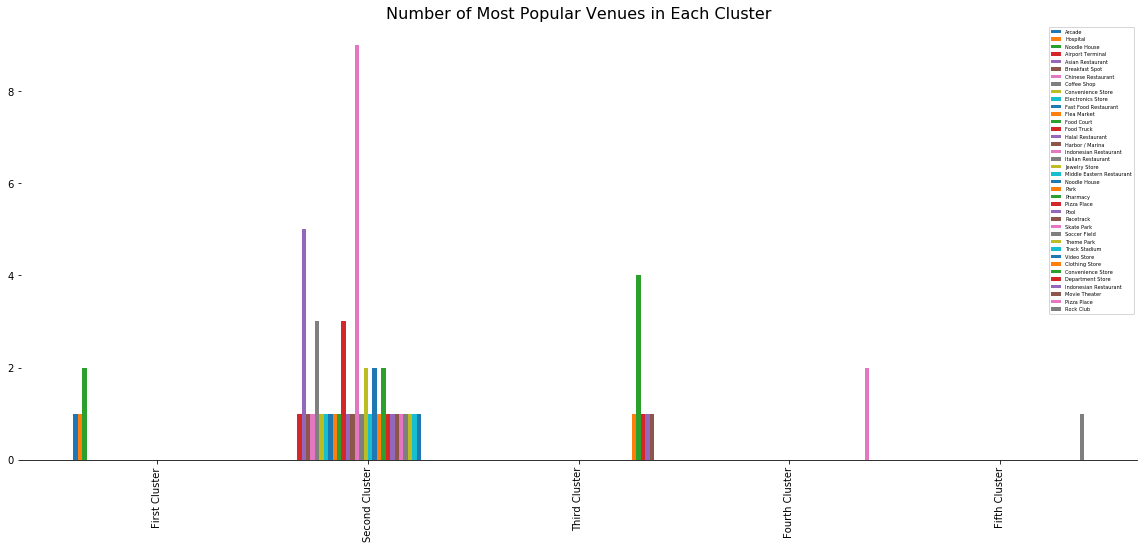

In [170]:
#colorslist=['#5cb85c','#5bc0de','#d9534f']

ax = cumT.plot(kind='bar', figsize=(20, 8), width=0.8)

ax.set_title("Number of Most Popular Venues in Each Cluster", fontsize=16)

rects=ax.patches

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

#for tick in ax.get_xticklabels():
    #tick.set_fontsize(14)
    
#for tick in ax.get_yticklabels():
    #tick.set_visible(False)
    
ax.legend(prop=dict(size=5))

What we can infer from the bar chart is that the 'Second Cluster' has the most amount of business engagement potential as the variety of popular venues in that cluster is astounding compared to the others. Hence, the 'Second Cluster' is where we should plant our bussiness to start.

Next, we shall find out top 10 subdistricts that has the greatest amount of popular venues to ensure that we get the greatest amount of business engagement.

In [174]:
novenues=pd.DataFrame(jakarta_venues.groupby('Subdistrict').count()['Venue'])
novenues=novenues.sort_values(by='Venue', ascending=False)
novenues.head()

,Venue
Subdistrict,
Rawamangun,32
Cipinang Melayu,29
Bali Mester,25
Kebon Manggis,17
Pal Meriam,17


We'll plot a bar chart illustrating the amount of popular venues of each subdistricts

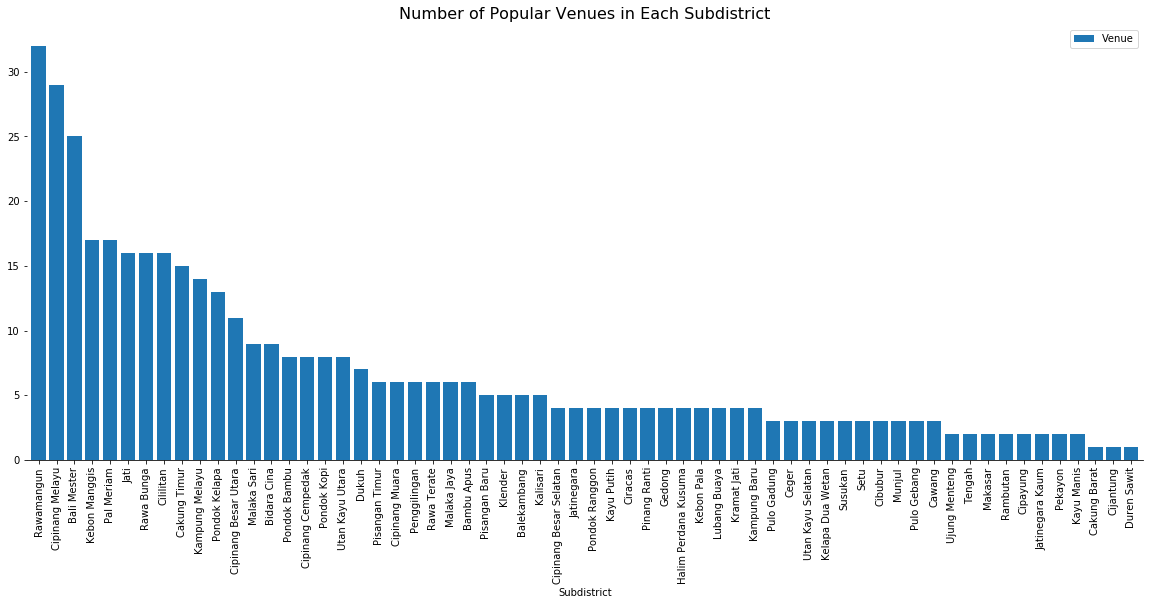

In [176]:
#colorslist=['#5cb85c','#5bc0de','#d9534f']

ax = novenues.plot(kind='bar', figsize=(20, 8), width=0.8)

ax.set_title("Number of Popular Venues in Each Subdistrict", fontsize=16)

rects=ax.patches

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

#for tick in ax.get_xticklabels():
    #tick.set_fontsize(14)
    
#for tick in ax.get_yticklabels():
    #tick.set_visible(False)
    

We shall make a new dataframe containing the top 10 subdistricts with the most amount of popular venues

In [182]:
finale=novenues.head(10)
finale=finale.reset_index()
finale

,Subdistrict,Venue
0,Rawamangun,32
1,Cipinang Melayu,29
2,Bali Mester,25
3,Kebon Manggis,17
4,Pal Meriam,17
5,Jati,16
6,Rawa Bunga,16
7,Cililitan,16
8,Cakung Timur,15
9,Kampung Melayu,14


We will exclude subdistrict that are not in the 'Second Cluster"

Since we're opening a coffee shop, we're also excluding subdistrict that has 'Coffee Shop' as the first most common venue to ensure at least we don't have a considerable competitors. 

In [180]:
second_clusterx=second_cluster[['Subdistrict','1st Most Common Venue']]
second_clusterx=second_clusterx.drop(second_clusterx[second_clusterx ['1st Most Common Venue'] == 'Coffee Shop'].index)
second_clusterx.head()

,Subdistrict,1st Most Common Venue
0,Balekambang,Park
2,Cawang,Noodle House
3,Cililitan,Fast Food Restaurant
4,Dukuh,Indonesian Restaurant
6,Tengah,Racetrack


### Final Results

Finally, we have arrived at the final results. Here are the 10 subdistricts in East Jakarta that have the most potential of business engagement (or foot traffic) to establish a new coffee shop in.

In [183]:
ooh=finale.merge(second_clusterx, left_on='Subdistrict', right_on='Subdistrict')[['Subdistrict', '1st Most Common Venue', 'Venue']]
ooh

,Subdistrict,1st Most Common Venue,Venue
0,Rawamangun,Indonesian Restaurant,32
1,Cipinang Melayu,Indonesian Restaurant,29
2,Bali Mester,Chinese Restaurant,25
3,Kebon Manggis,Indonesian Restaurant,17
4,Pal Meriam,Indonesian Restaurant,17
5,Jati,Indonesian Restaurant,16
6,Rawa Bunga,Jewelry Store,16
7,Cililitan,Fast Food Restaurant,16
8,Cakung Timur,Theme Park,15
9,Kampung Melayu,Convenience Store,14


## Result Analysis & Discussion<a name="results"></a>

As you may have seen earlier in the Analysis section, we have sucessfully deduce the **top 10 subdistricts in East Jakarta that has the most amount of business engagement** by **comparing the variety of the most common venue of each cluster** using foursquare data and sorting by **the number of popular venues present in each clusters**. Those subdistricts, in descending order of number of popular venues, are Rawamangun, Cipinang Melayu, Bali Mester, Kebon Manggis, Pal Meriam, Jati, Rawa Bunga, Cililitan, Cakung Timur, and Kampung Melayu. **These subdistricts are also a good place to establish a coffee shop as these subdistricts don't have a coffee shop as their most popular venue.**

Please do bear in mind that by saying that we are successful in doing this analysis, this analysis is not without its flaws, as there are two big issues that need to be adressed. The first one and the most glaring issue is the issue of clustering. In the process of clustering (you may refer to the [k-means clustering](#clustering) section above) you can see that the elbow method shows that it needs at least 14 clusters for the analysis. **This shows that the demographic of subdistricts in East Jakarta are so heterogeneous that it takes at least 14 clusters to cluster the subdistricts of East Jakarta**. Surely, we did not proceed with applying 14 clusters to cluster East Jakarta, as it defeats the purpose of clustering itself. Hence we settled on 5 clusters as the graph shows a little bit of an 'elbow' at 5 clusters.

The second one is the lack of public data access in Indonesia. In doing this analysis we could say that we've 'scraped the bottom of the barrel' in  the search of available socio-economic data in Indonesia. Most of the socio-economic data compiled by the goverment regarding the information of each subdistrict are not open to the public. Hence we have to make do by using the available 3rd party data and by using APIs

There are some pointers as to how to improve this analyisis. The first one being, using another technique of clustering as the k-means method failed to produce a reasonable amount of clusters to consider. The second one is to utilize other sets of data such as the GDP of each subdistricts in Jakarta to further restrict the subdistricts that has a higher amount of income as it equates with having a higher buying power. The last one is to ensure the accuracy of the data, as the data may not represent the real world earnestly; it could have a discrepancy that we have to sort out manually.

## Conclusion <a name="conclusion"></a>

We have sucessfully deduce the top 10 subdistricts in East Jakarta which are suitable for establishing a new coffee shop in. However, please do bear in mind that an additional analysis is fully encouraged for interested entrepreneurs as this is based only on a single dataset, which was foursquare data.